In [118]:
# from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import textacy

from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.metrics.regression import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder

from dumb_predictors import MeanRegressor, ModeClassifier

import pandas as pd
import numpy as np
import pickle
import datetime as dt
import glob
import sys
import os.path

from keras.models import Sequential
from keras.layers import Dense, Activation

np.set_printoptions(formatter={'float_kind':lambda x: "%.4fdf" % x})

import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY, date2num
import seaborn as sb



In [42]:

class Fab(object):
    """
    Fab - FOMC Analyzer Bot

    A class to create predictions on the FOMC meeting minutes
    """

    def __init__(self, regression=True):

        self.regression = regression
        self.labels = None
        self.last_test = None
        self.last_predict = None
        self.meeting_statements = self.get_meeting_statements('../data/minutes.pickle')
        self.prices = self.get_prices()
        self.set_labels()

        self.all_data_df = None  # a data frame that holds all the X and y's 
        self.X = None
        self.y = None

        print("Available tickers:")
        print(", ".join(list(self.labels.keys())))


    def get_meeting_statements(self, filename='../data/minutes_df.pickle'):
        with open(filename, 'rb') as f:
            print("Loading saved statements")
            return pickle.load(f)


    def get_prices(self, filename='../data/*.csv', pickle_path='../data/prices.pickle', refresh=False):
        # A dictionary of dataframes.  One for each 
        # note the timezone issues need to be rechecked prior to running live

        if refresh is False and os.path.exists(pickle_path):
            print("Loading saved prices")
            with open(pickle_path, 'rb') as f:
                return pickle.load(f)

        prices = dict()
        col_names = ['date', 'open', 'high', 'low', 'close', 'volume', 'count', 'WAP']
        for file in glob.glob(filename):
            ticker = file.split('/')[-1].split('.')[0]
            prices[ticker] = pd.read_csv(file, parse_dates=['date'], infer_datetime_format=True,names=col_names).drop_duplicates()
            prices[ticker].set_index('date', inplace=True)
            prices[ticker].index = prices[ticker].index.tz_localize('America/Los_Angeles').tz_convert('America/New_York').tz_localize(None)
            prices[ticker]['close-MA-4'] = self.fit_moving_average_trend(prices[ticker]['close'], window=4)
        return prices


    def write_prices(self, pickle_path='../data/prices.pickle'):
        with open(pickle_path, "wb") as f:
            pickle.dump(self.prices, f)


    def set_labels(self, index=None, pickle_path='../data/labels.pickle', refresh=False):

        if refresh is False and os.path.exists(pickle_path):
            print("Loading saved labels")
            with open(pickle_path, 'rb') as f:
                self.labels = pickle.load(f)
                return self.labels

        if index is None:
            index = self.meeting_statements.index

        # Selector to get only prices right before and right after the statement release
        pre_post_FOMC_time_selector = []
        for date in index:
            pre_post_FOMC_time_selector.extend(pd.date_range(date.replace(hour=13, minute=30), periods=2, freq='2 H'))

        prices_FOMC = dict()
        for key in self.prices.keys():
            prices_FOMC[key] = self.prices[key].loc[pre_post_FOMC_time_selector][['close-MA-4']].dropna()

        # each value in this dictionary is a two columns of values.  
        y_dfs = dict()
        for key in prices_FOMC:
            y_dfs[key] = prices_FOMC[key].groupby(prices_FOMC[key].index.date).diff().dropna() 
            y_dfs[key]['fomc-close-MA-4-pct'] = (y_dfs[key]['close-MA-4'] / self.prices[key].loc[y_dfs[key].index]['close'])

            # Removes the time from the index since now we are left with one prediction a day
            y_dfs[key].index = y_dfs[key].index.normalize()

            # Binary column stores 1 if market went up, 0 otherwise
            y_dfs[key]['binary'] = (y_dfs[key]['close-MA-4'] > 0) * 1
            y_dfs[key].columns = ['abs-delta', 'pct-delta', 'binary']
        self.labels = y_dfs
        return self.labels


    def write_labels(self, pickle_path='../data/labels.pickle'):
        with open(pickle_path, "wb") as f:
            pickle.dump(self.labels, f)


#     def lemmatize_descriptions(self, meeting_statements):
#         lemmatized = []
#         for statement in meeting_statements:
#             doc = nlp(statement)
#             lemmatized.append(" ".join([token.lemma_ for token in doc]))
#         return lemmatized
            

#     def get_vectorizer(self, meeting_statement, num_features=5000):
#         vect = TfidfVectorizer(max_features=num_features, stop_words='english')
#         return vect.fit(meeting_statement)


    def fit_moving_average_trend(self, series, window=6):
        return series.rolling(window=window,center=False).mean()


    def run_model(self, model, X_train, X_test, y_train, y_test):

        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)

        self.last_test = y_test
        self.last_predict = y_predict

        # fpr, tpr, thresholds = roc_curve(y_test, y_predict)
        if self.regression:
            return r2_score(y_test, y_predict), \
                   mean_squared_error(y_test, y_predict), \
                   mean_absolute_error(y_test, y_predict)
        else:
            return roc_auc_score(y_test, y_predict), \
                   accuracy_score(y_test, y_predict), \
                   f1_score(y_test, y_predict), \
                   precision_score(y_test, y_predict), \
                   recall_score(y_test, y_predict)


    def run_test(self, models, desc_train, desc_test, y_train, y_test):
#         vect = self.get_vectorizer(desc_train)
#         X_train = vect.transform(desc_train).toarray()
#         X_test = vect.transform(desc_test).toarray()

        X_train = desc_train
        X_test = desc_test
        
        if self.regression:
            print("r2\tmse\tmae")
            for model in models:
                name = model.__class__.__name__
                r2, mse, mae = self.run_model(model, X_train, X_test, y_train, y_test)
                print("%.4f\t%.4f\t%.4f\t%s" % (r2, mse, mae, name))
            return mse
        else:
            print("auc\tacc\tf1\tprec\trecall")
            for model in models:
                name = model.__class__.__name__
                auc_score, acc, f1, prec, rec = self.run_model(model, X_train, X_test, y_train, y_test)
                print("%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%s" % (auc_score, acc, f1, prec, rec, name))
            return acc


    def compare_models(self, desc, y, models, splits=6):

        # desc_train, desc_test, y_train, y_test = train_test_split(desc, labels)

        tscv = TimeSeriesSplit(n_splits=splits)

        for train_index, test_index in tscv.split(desc):
            desc_train, desc_test = desc[train_index], desc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            print("")
            print("Length: train {}, test {}".format(len(train_index), len(test_index)))
            print("Balance: train {}, test {}".format(np.sum(y_train)/float(len(y_train)), 
                                                      np.sum(y_test)/float(len(y_test))) )
            print ("-----------------------------")
#             print "Without Lemmatization:"
            self.run_test(models, desc_train, desc_test, y_train, y_test)

#             print("-----------------------------")
#             print("With Lemmatization:")
#             self.run_test(models, self.lemmatize_descriptions(desc_train),
#                            self.lemmatize_descriptions(desc_test), y_train, y_test)
#             print("-----------------------------")


    def predict(self, meeting_statement, timestamp, tickers):
        """
        Predicts the output of the given meeting_statement to the tickers in tickers.  The prerequisite
        of this method is that prices of the instruments are already preloaded.

        Designed for live prediction during FOMC meeting days 

        meeting_statement -- a new meeting statement
        """

        # Wait until 1:55 PM
        # keep updating prices until 2 PM.
        # While refreshing FOMC site for minute:
        #   statement = get statement
        # if prices have already been updated
        #   X = self.get_features(meeting_statement, timestamp, tickers) #one row matrix
        #   return self.model.predict(X)
        pass

    def anticipate_and_predict(self, tickers=['SHY-USD-TRADES']):
        """

        """
        # Wait until 1:45 PM
        # keep updating prices until 2 PM.
        # While refreshing FOMC site for minute:
        #   statement = get statement
        #   timestamp = current time
        # set closing prices as current time
        # return predict(statement, timestamp, tickers)
        pass


    def run(self, tickers=['SHY-USD-TRADES']):
        """
        Adds the features into X for prediction and then runs several different models to compare
        their performance.  Sets the best model as the instance's model.

        """

        # sequential = Sequential()
        # sequential.add(Dense(units=64, input_dim=100))
        # sequential.add(Activation('relu'))
        # sequential.add(Dense(units=10))
        # sequential.add(Activation('softmax'))
        # sequential.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



        # build NLP df with features
        corpus = textacy.Corpus(lang='en')
        corpus.add_texts(self.meeting_statements['statements'].values, n_threads=4)
        self.doc_term_matrix, self.id2term = textacy.vsm.doc_term_matrix((doc.to_terms_list(ngrams=3, 
                                                                                  named_entities=True, 
                                                                                  as_strings=True) for doc in corpus),
                                                               weighting='tfidf', 
                                                               normalize=False, 
                                                               smooth_idf=True, 
#                                                                min_df=2, 
#                                                                max_df=0.95
                                                              )
        # take index from self.labels and build features based on prices



        # merge the NLP features with the prices features on the index of each ticker

        self.X = self.doc_term_matrix

        # Parameter tuning on RF





        if self.regression:



            models = [MeanRegressor(),
                      GradientBoostingRegressor(), 
                      RandomForestRegressor(n_estimators=300)]
                      # , 
                      # GradientBoostingRegressor(),
                      # # sequential, 
                      # MeanRegressor()]
            
        else:
            # models = [LogisticRegression(), 
            #           KNeighborsClassifier(), 
            #           MultinomialNB(), 
            #           RandomForestClassifier(bootstrap=False), 
            #           # sequential, 
            #           GradientBoostingClassifier(),
            #           SVC(degree=4),
            #           ModeClassifier()]


            models = [ModeClassifier(),
                      RandomForestClassifier(n_estimators=200),
                      RandomForestClassifier(n_estimators=225),
                      RandomForestClassifier(n_estimators=250),
                      RandomForestClassifier(n_estimators=275),
                      RandomForestClassifier(n_estimators=300),
                      RandomForestClassifier(n_estimators=325),
                      RandomForestClassifier(n_estimators=400),
                      RandomForestClassifier(n_estimators=500),
                      RandomForestClassifier(n_estimators=600)]


        for ticker in tickers:
            if ticker in self.labels.keys():
                print(ticker)
                print("distribution of labels:")
                for i, count in enumerate(np.bincount(self.labels[ticker]['binary'].values)):
                    print("%d: %d" % (i, count))
                if self.regression:
                    # min = self.labels[ticker]['pct-delta'].values.min()
                    # max = self.labels[ticker]['pct-delta'].values.max()
                    self.compare_models(self.meeting_statements.loc[self.labels[ticker].index]['statements'], 
                                    self.labels[ticker]['abs-delta'].values, models)
                else:
                    selector = np.array([True if i in self.labels[ticker].index else False for i in self.meeting_statements.index])
                    self.compare_models(self.X.toarray()[selector], 
                                        self.labels[ticker]['binary'].values, models)



In [4]:
fab = Fab(regression=False)
fab.run()

Loading saved statements
Loading saved prices
Loading saved labels
Available tickers:
EUR-USD-MIDPOINT, XLU-USD-TRADES, XLB-USD-TRADES, GDX-USD-TRADES, XLF-USD-TRADES, OIL-USD-TRADES, XLV-USD-TRADES, SPY-USD-TRADES, SPY-OIV, USD-CAD-MIDPOINT, XLK-USD-TRADES, XLI-USD-TRADES, XLE-USD-TRADES, USD-JPY-MIDPOINT, SHY-USD-TRADES, XLY-USD-TRADES
SHY-USD-TRADES
distribution of labels:
0: 41
1: 62

Length: train 19, test 14
Balance: train 0.5263157894736842, test 0.5714285714285714
-----------------------------
auc	acc	f1	prec	recall
0.5000	0.5714	0.7273	0.5714	1.0000	ModeClassifier
0.5208	0.5714	0.7000	0.5833	0.8750	RandomForestClassifier
0.6042	0.6429	0.7368	0.6364	0.8750	RandomForestClassifier
0.7708	0.7857	0.8235	0.7778	0.8750	RandomForestClassifier
0.5208	0.5714	0.7000	0.5833	0.8750	RandomForestClassifier
0.6042	0.6429	0.7368	0.6364	0.8750	RandomForestClassifier
0.5417	0.5714	0.6667	0.6000	0.7500	RandomForestClassifier
0.6250	0.6429	0.7059	0.6667	0.7500	RandomForestClassifier
0.5417	0.5714	

In [ ]:
debug

In [ ]:
corpus = textacy.Corpus('en', texts=fab.meeting_statements['statements'].values)

In [ ]:
content = '''
    The apparent symmetry between the quark and lepton families of
    the Standard Model (SM) are, at the very least, suggestive of
    a more fundamental relationship between them. In some Beyond the
    Standard Model theories, such interactions are mediated by
    leptoquarks (LQs): hypothetical color-triplet bosons with both
    lepton and baryon number and fractional electric charge.'''
metadata = {
    'title': 'A Search for 2nd-generation Leptoquarks at √s = 7 TeV',
    'author': 'Burton DeWilde',
    'pub_date': '2012-08-01'}
doc = textacy.Doc(content, metadata=metadata)
print(doc)

In [ ]:
doc.to_bag_of_terms()

In [ ]:
corpus = textacy.Corpus(lang='en')
corpus.add_texts(fab.meeting_statements['statements'].values, n_threads=4)

In [ ]:
idf = corpus.word_doc_freqs(normalize='lemma', weighting='idf', smooth_idf=True, as_strings=True)

In [ ]:
idf

In [ ]:
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix((doc.to_terms_list(ngrams=3, 
                                                                          named_entities=True, 
                                                                          as_strings=True) for doc in corpus),
                                                       weighting='tfidf', 
                                                       normalize=True, 
                                                       smooth_idf=True, 
                                                       min_df=2, 
                                                       max_df=0.95)

In [ ]:
doc_term_matrix[fab.labels['SHY-USD-TRADES'].index]

In [ ]:
fab.labels['SHY-USD-TRADES'].index in fab.meeting_statements.index

In [ ]:
id2term

In [ ]:
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix

In [ ]:
selector = [True if i in fab.labels[ticker].index else False for i in fab.meeting_statements.index]

In [5]:
textacy.vsm.doc_term_matrix?

In [34]:
plt.figure(fig_size=(12,8))
fab.prices['SHY-USD-TRADES'].loc['2017-03-15'].open.plot()

NameError: name 'plt' is not defined

In [123]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries=None, description=None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots(figsize=(12,6))
    fig.subplots_adjust(bottom=0.2)
#     if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
#         weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
#         ax.xaxis.set_major_locator(mondays)
#         ax.xaxis.set_minor_locator(alldays)
#     else:
#         weekFormatter = DateFormatter('%b %d, %Y')
#     ax.xaxis.set_major_formatter(weekFormatter)
    
    formatter = DateFormatter('%b %d, %H:%M')
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", 
                      # width = 0.01 
                      width = stick * .01
                    )
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.title(description)
    plt.show()

In [137]:
df = fab.prices['SHY-USD-TRADES'].loc['2017-03-15']
df.columns=['Open','High','Low','Close','Volume','Count','Wap','Close-MA-4']

In [93]:
df.reset_index(inplace=True)
df['date']=date2num(df['date'].astype(dt.date))

/Users/souljourner/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [97]:
df.head()

,Open,High,Low,Close,Volume,Count,Wap,Close-MA-4
date,,,,,,,,
2017-03-15 09:30:00,84.26,84.26,84.25,84.26,420,98,84.258,84.2550
2017-03-15 10:00:00,84.26,84.26,84.25,84.26,321,97,84.255,84.2575
2017-03-15 10:30:00,84.26,84.26,84.25,84.26,1554,112,84.258,84.2575
2017-03-15 11:00:00,84.25,84.26,84.25,84.26,411,102,84.254,84.2600
2017-03-15 11:30:00,84.26,84.26,84.25,84.26,607,91,84.258,84.2600


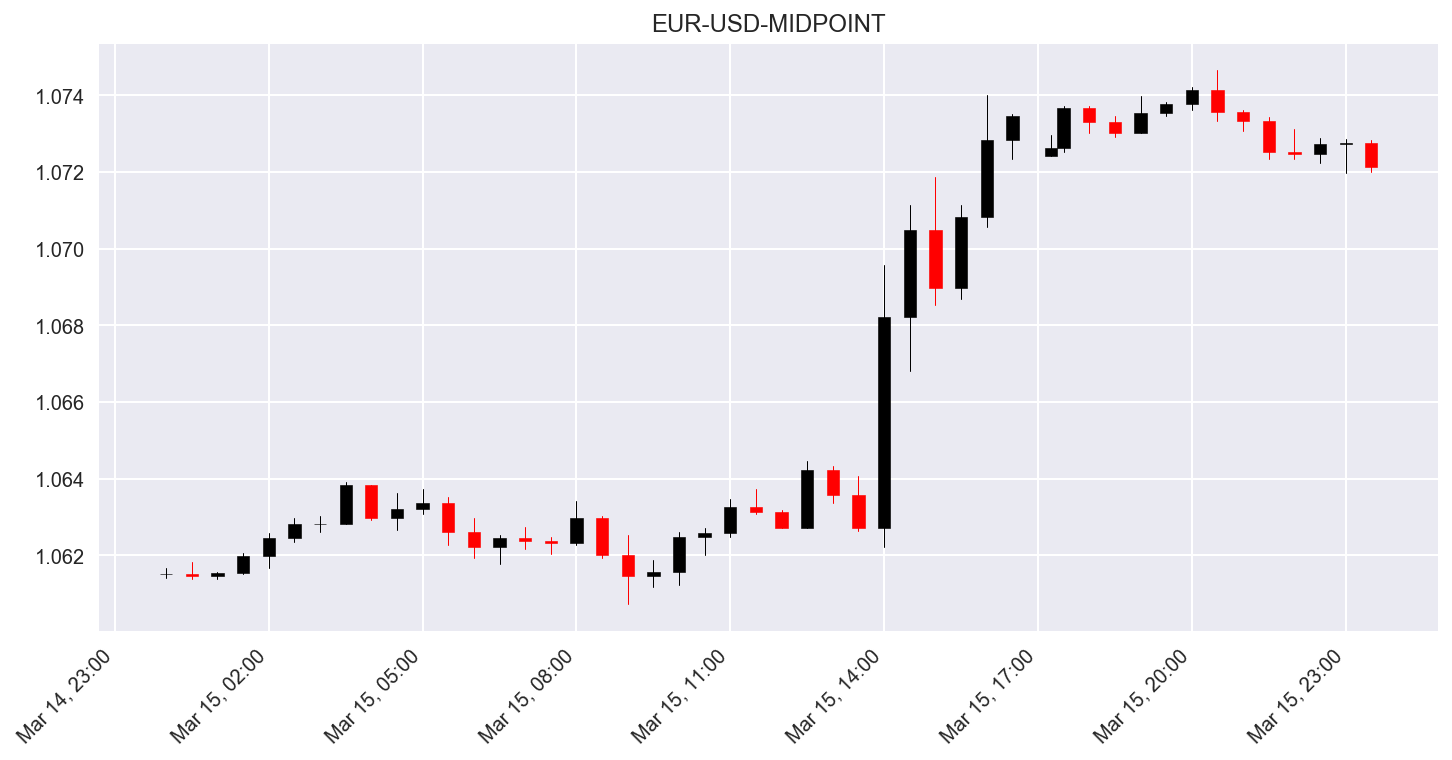

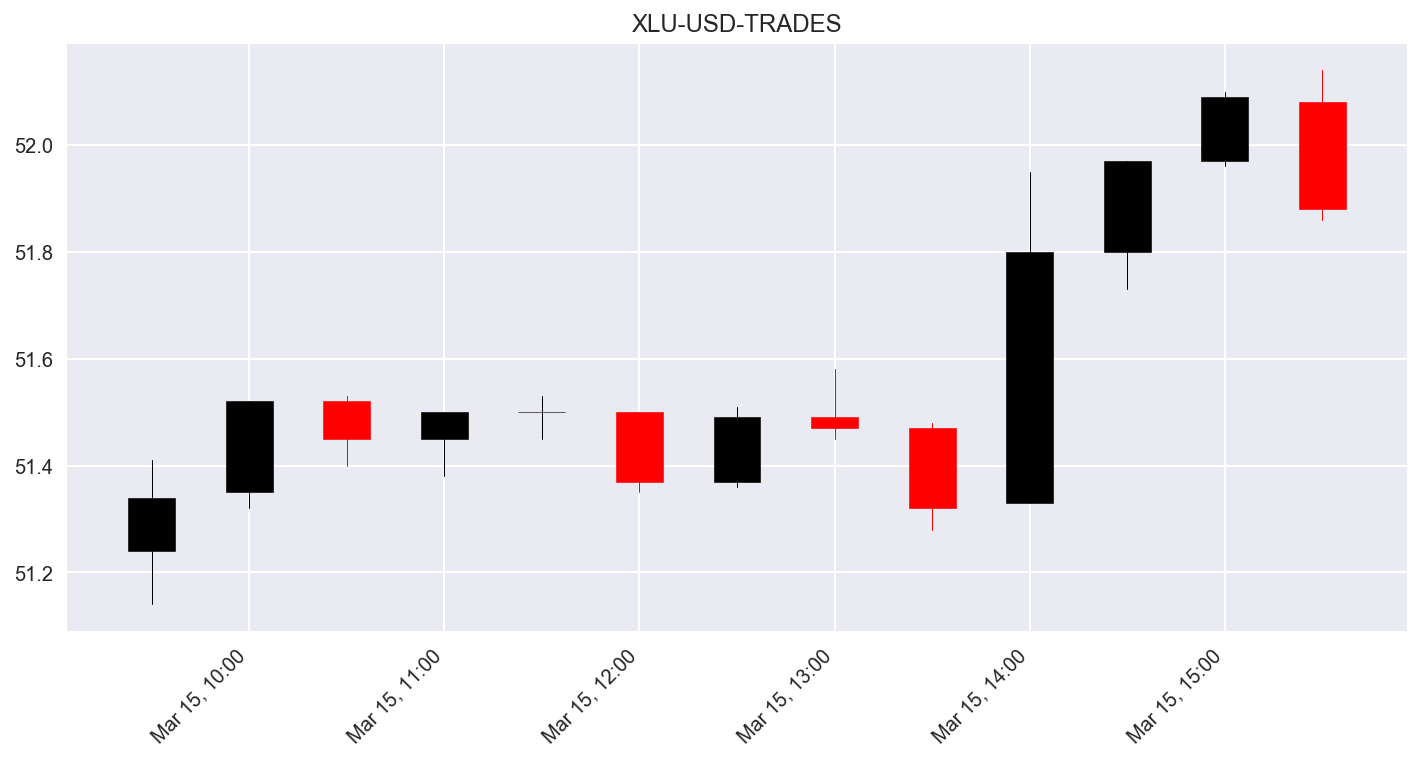

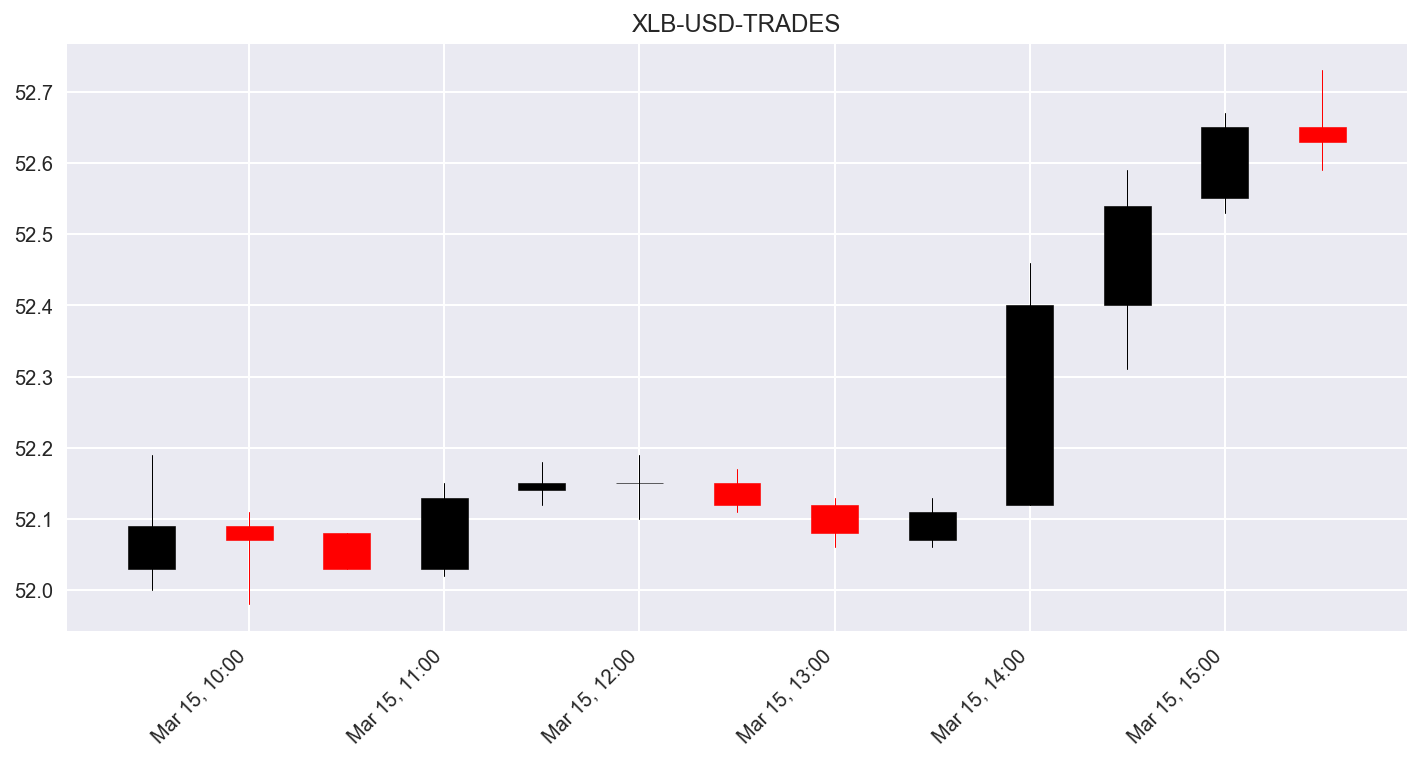

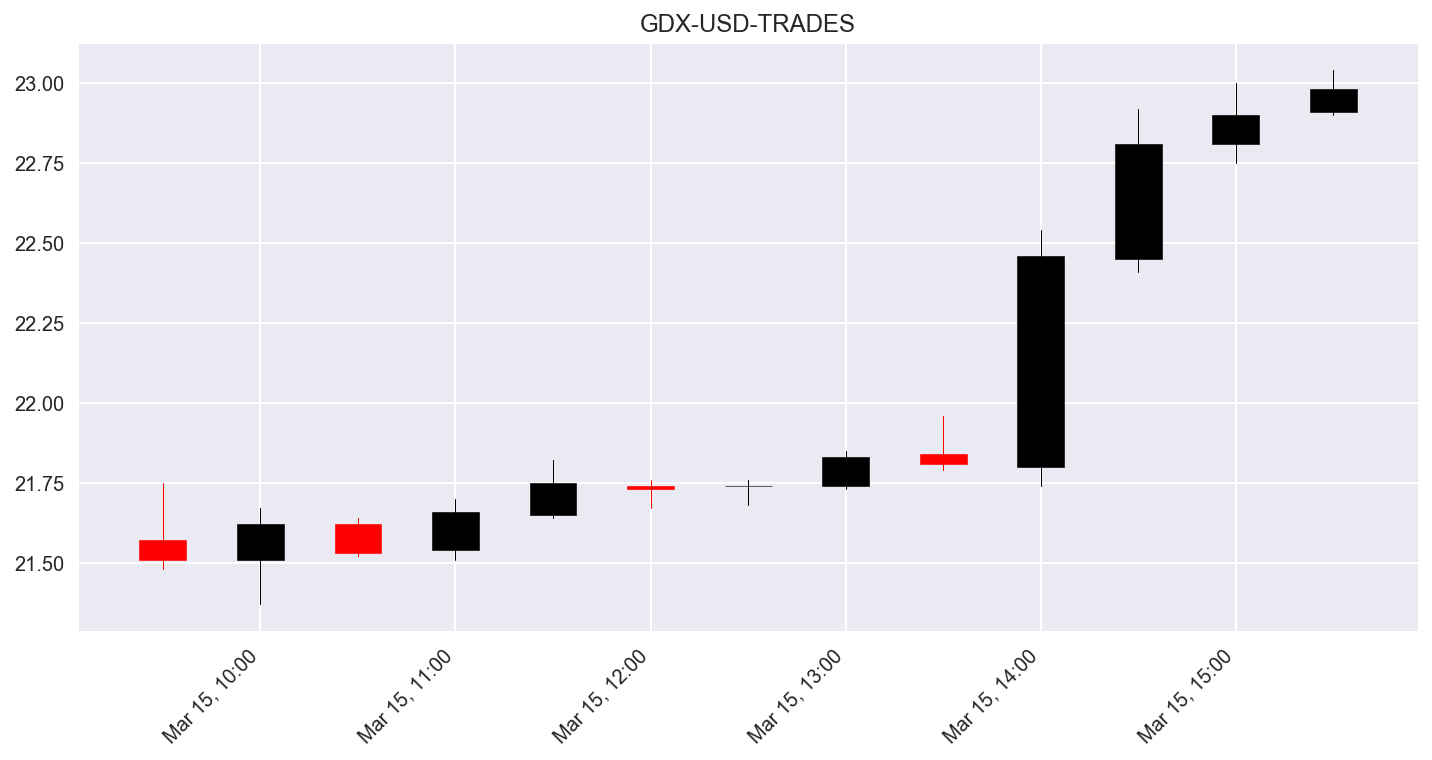

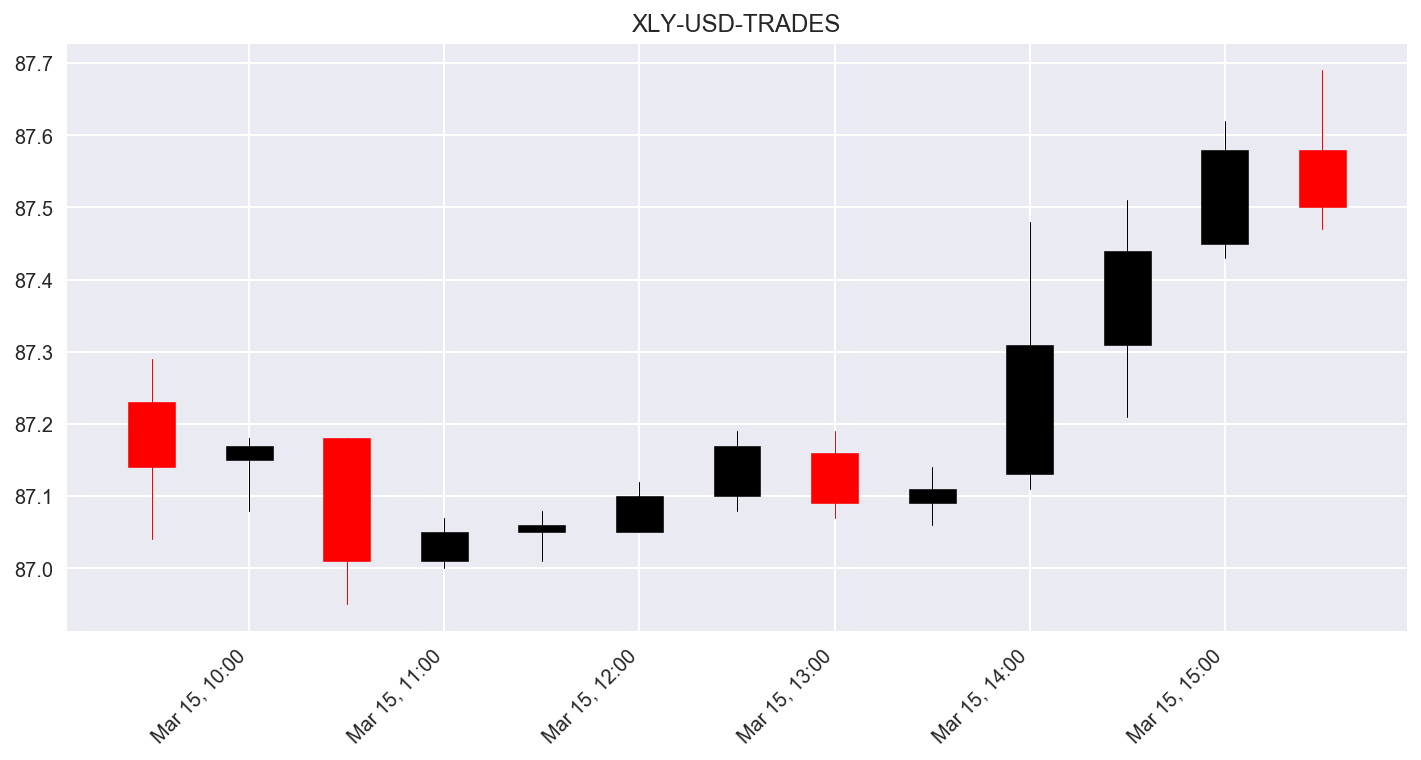

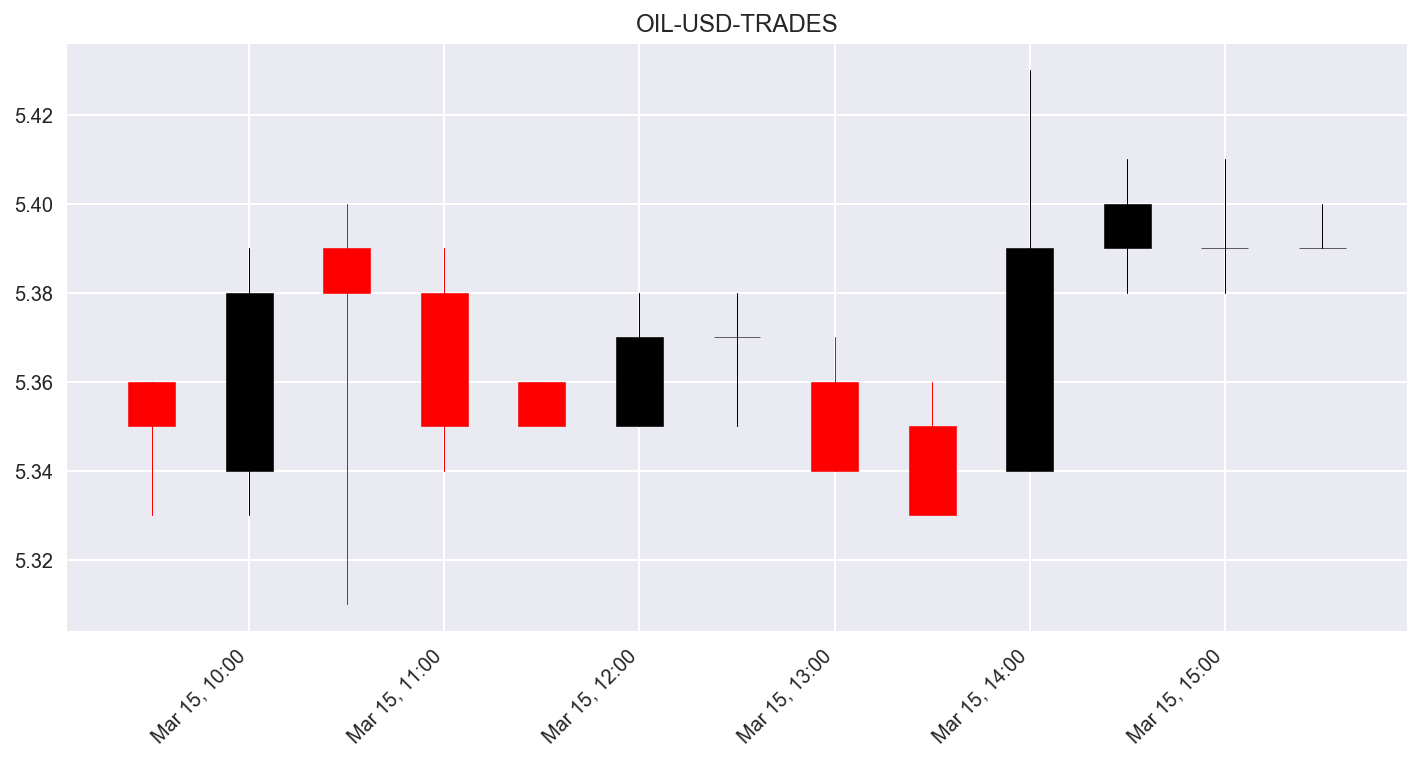

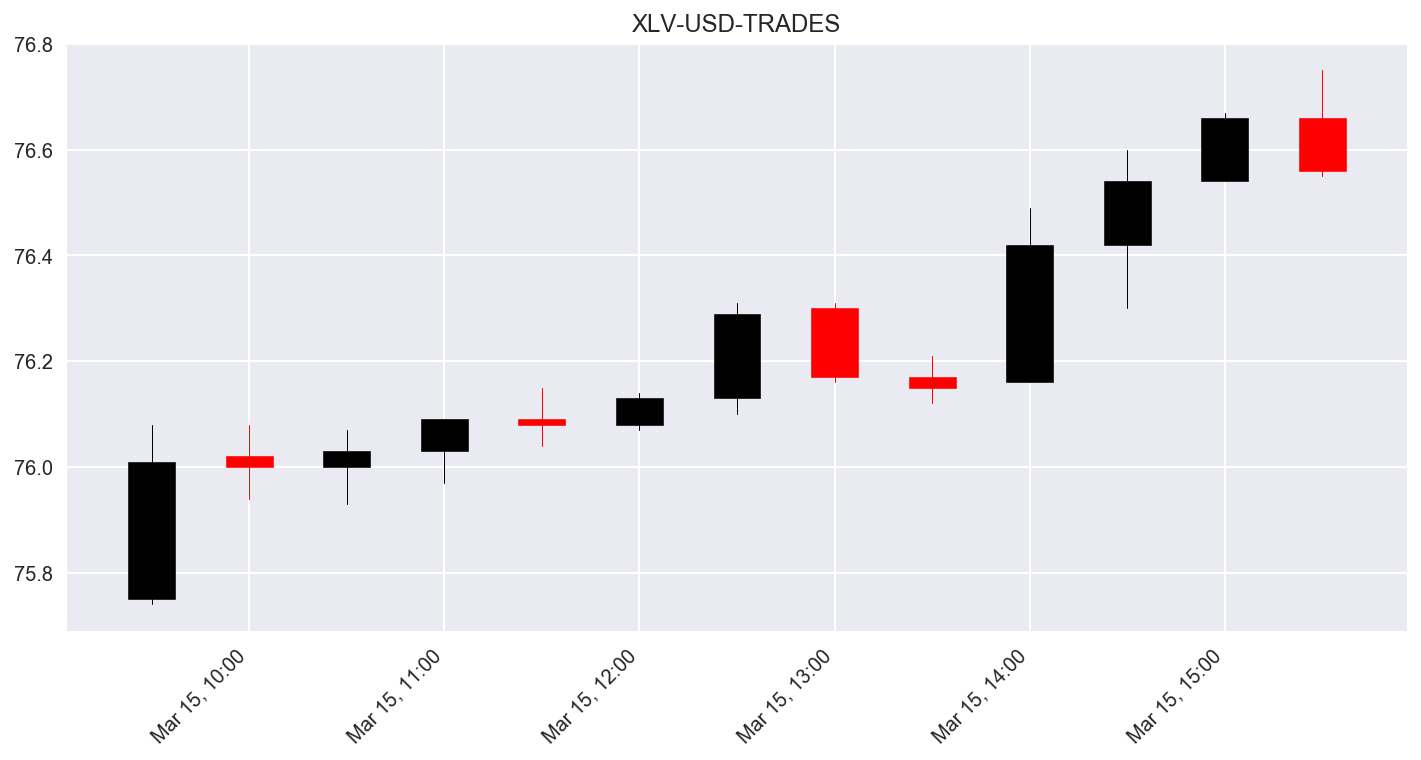

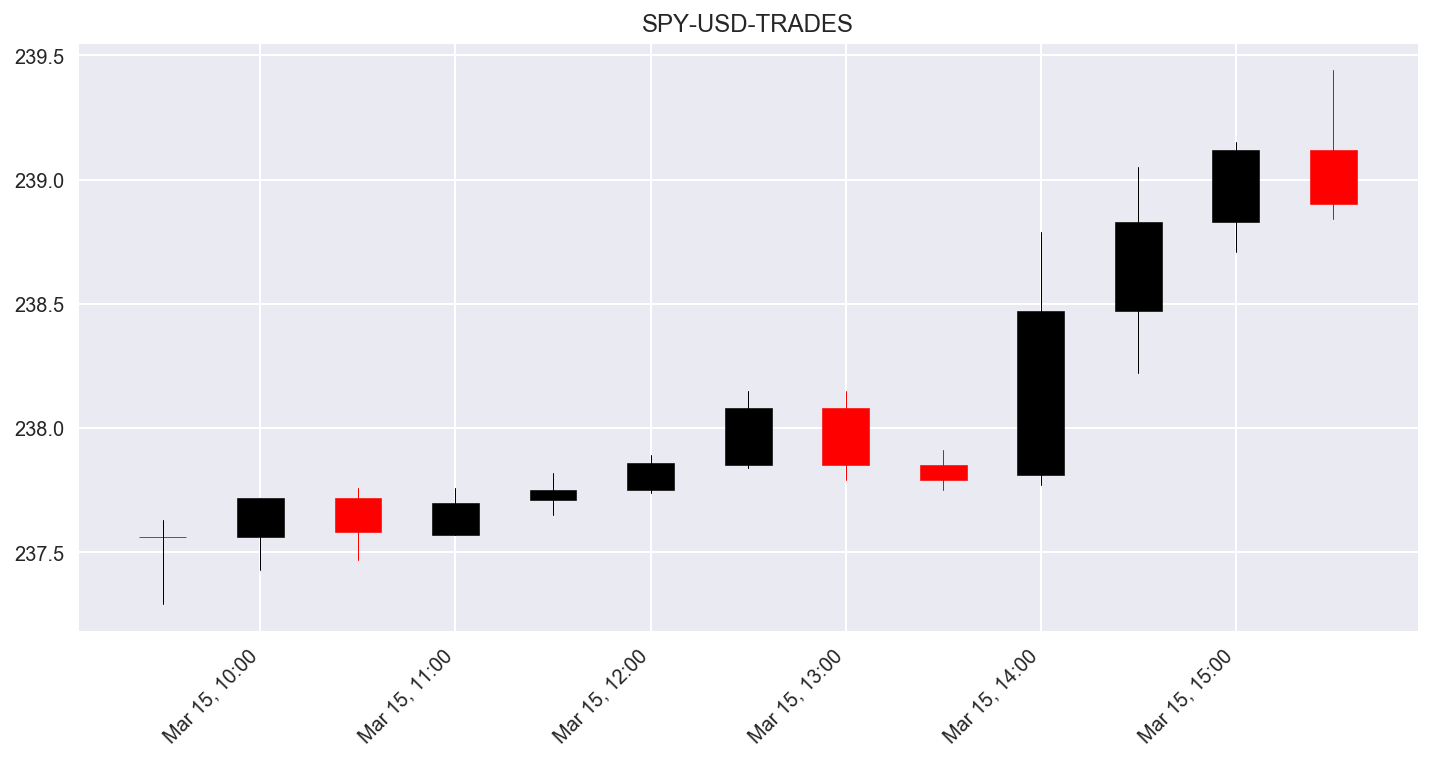

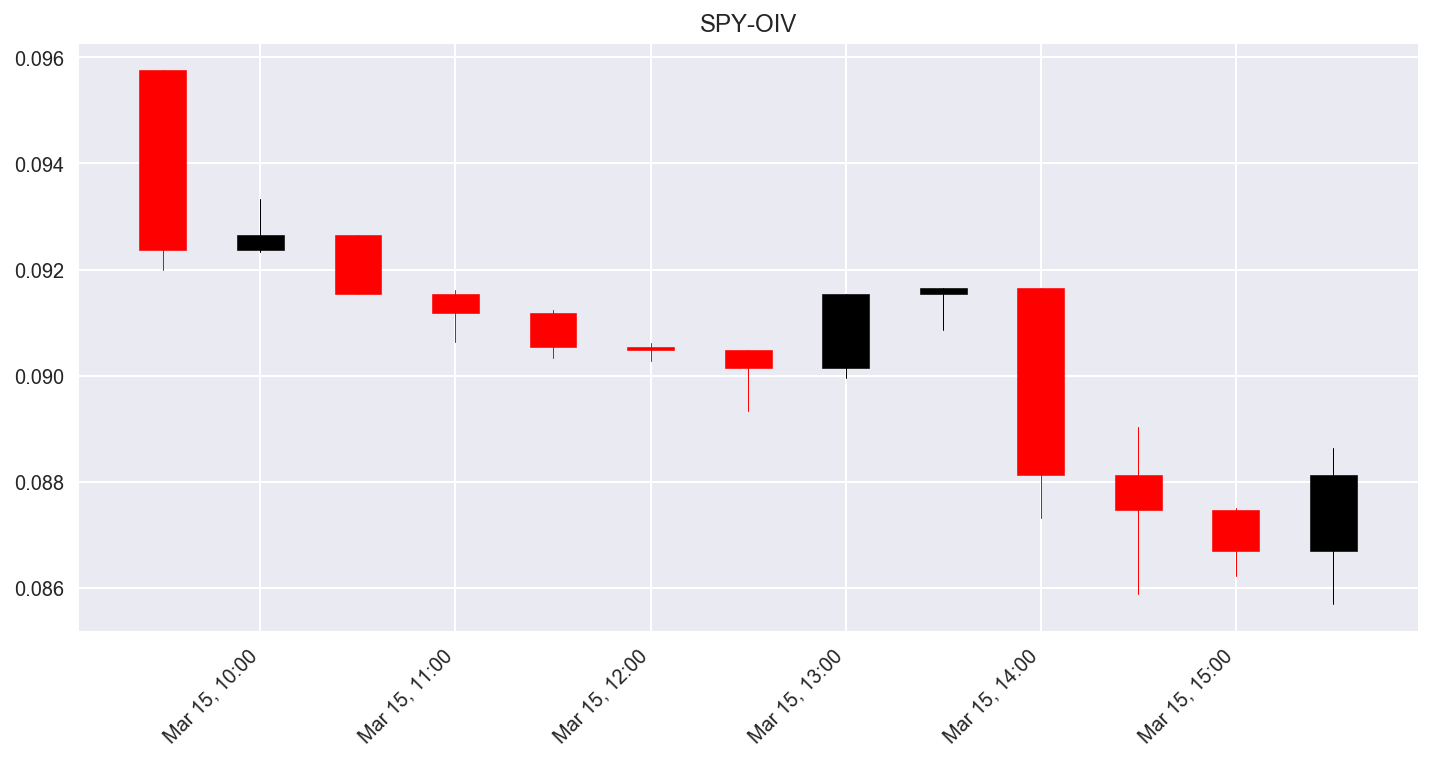

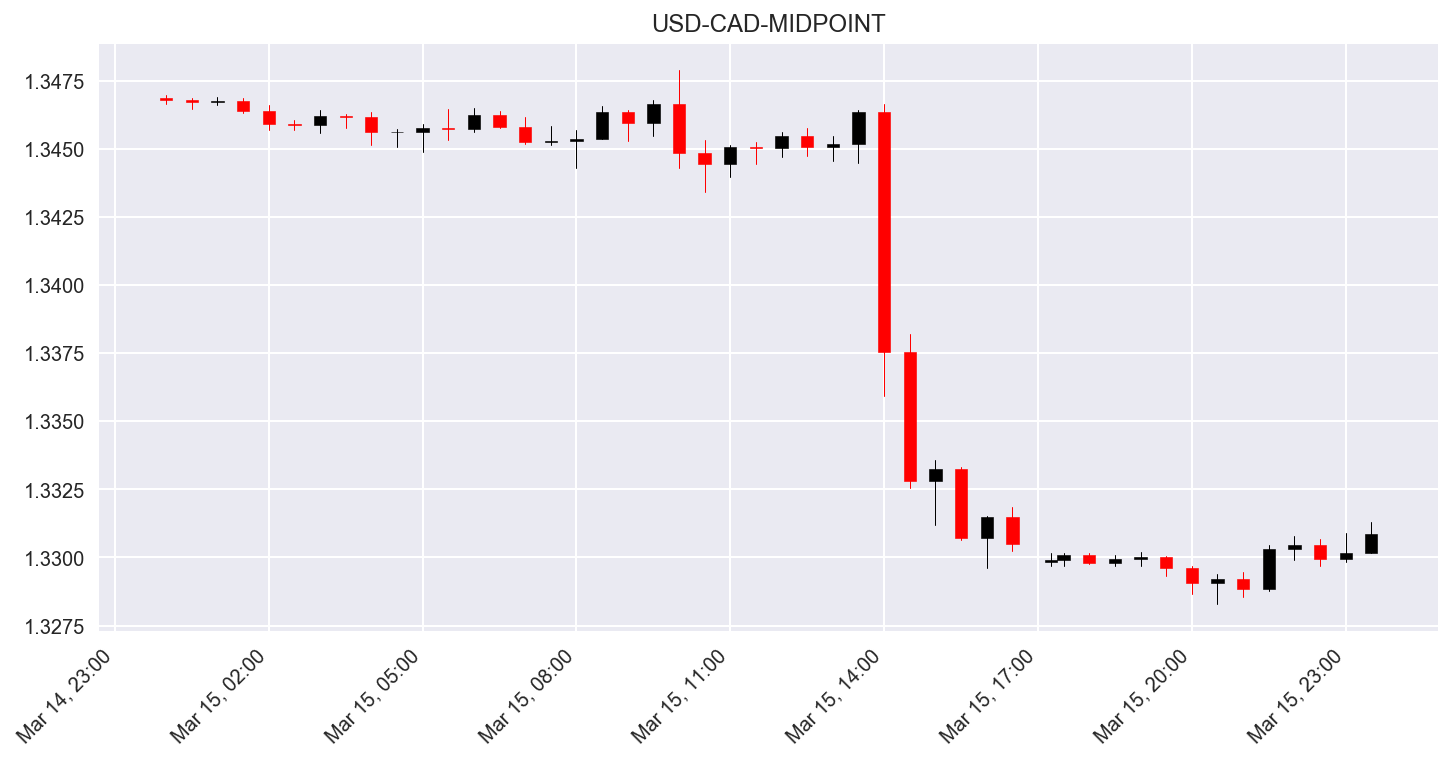

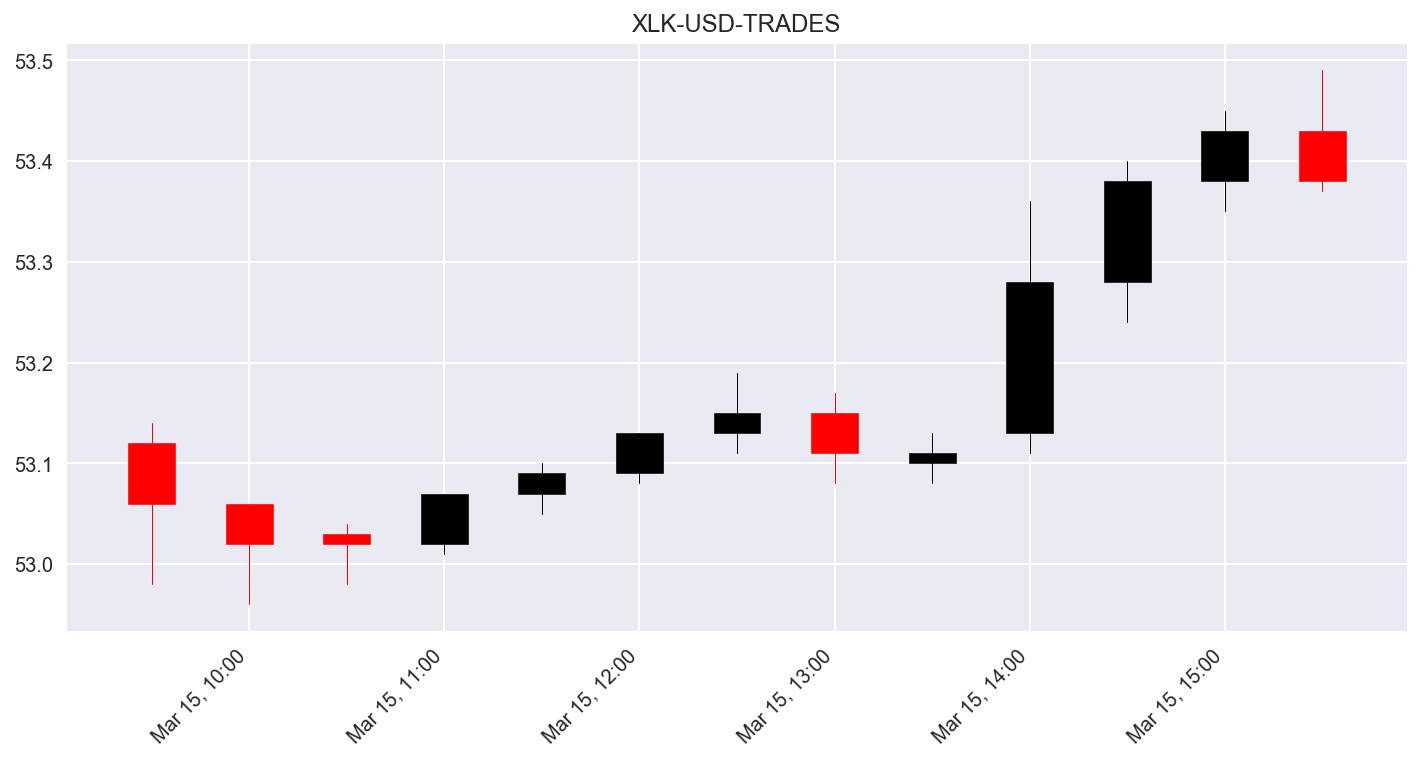

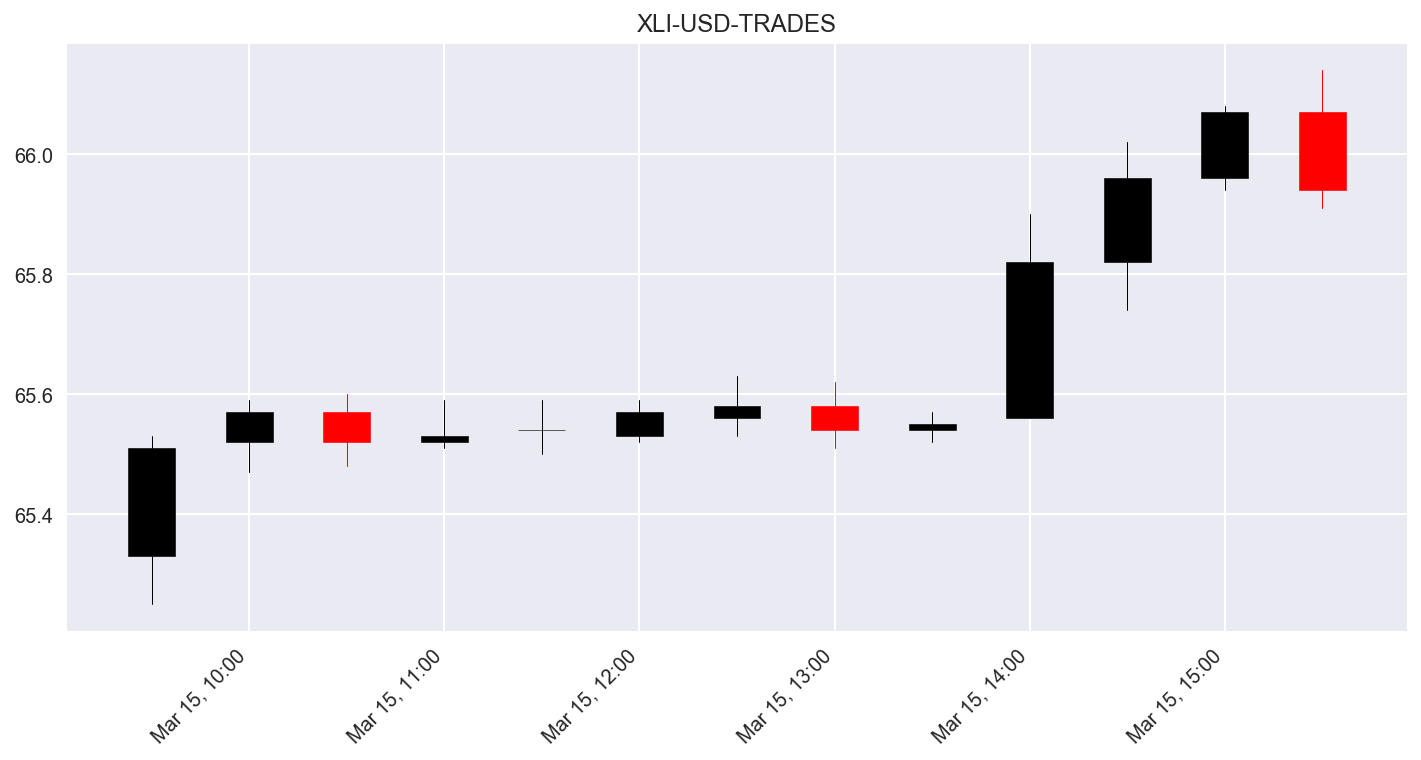

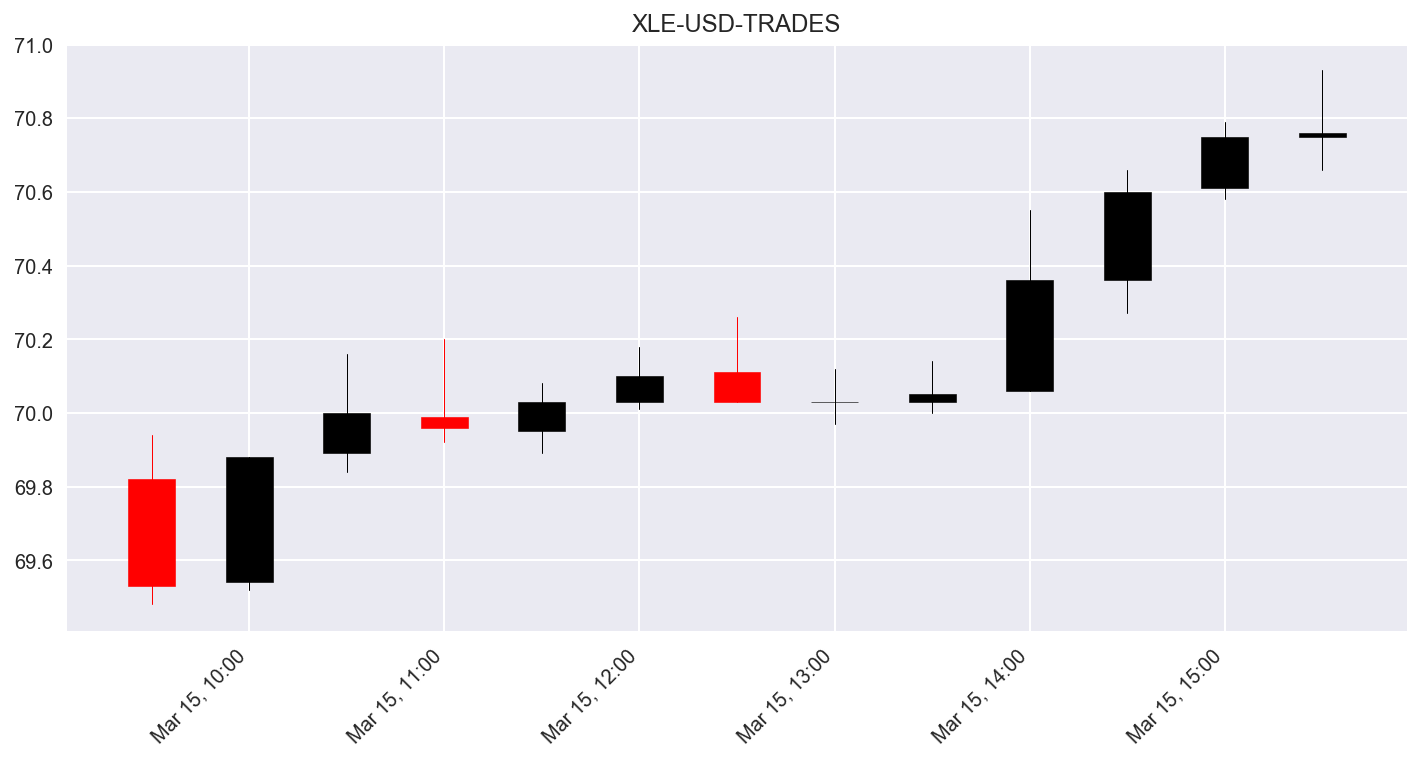

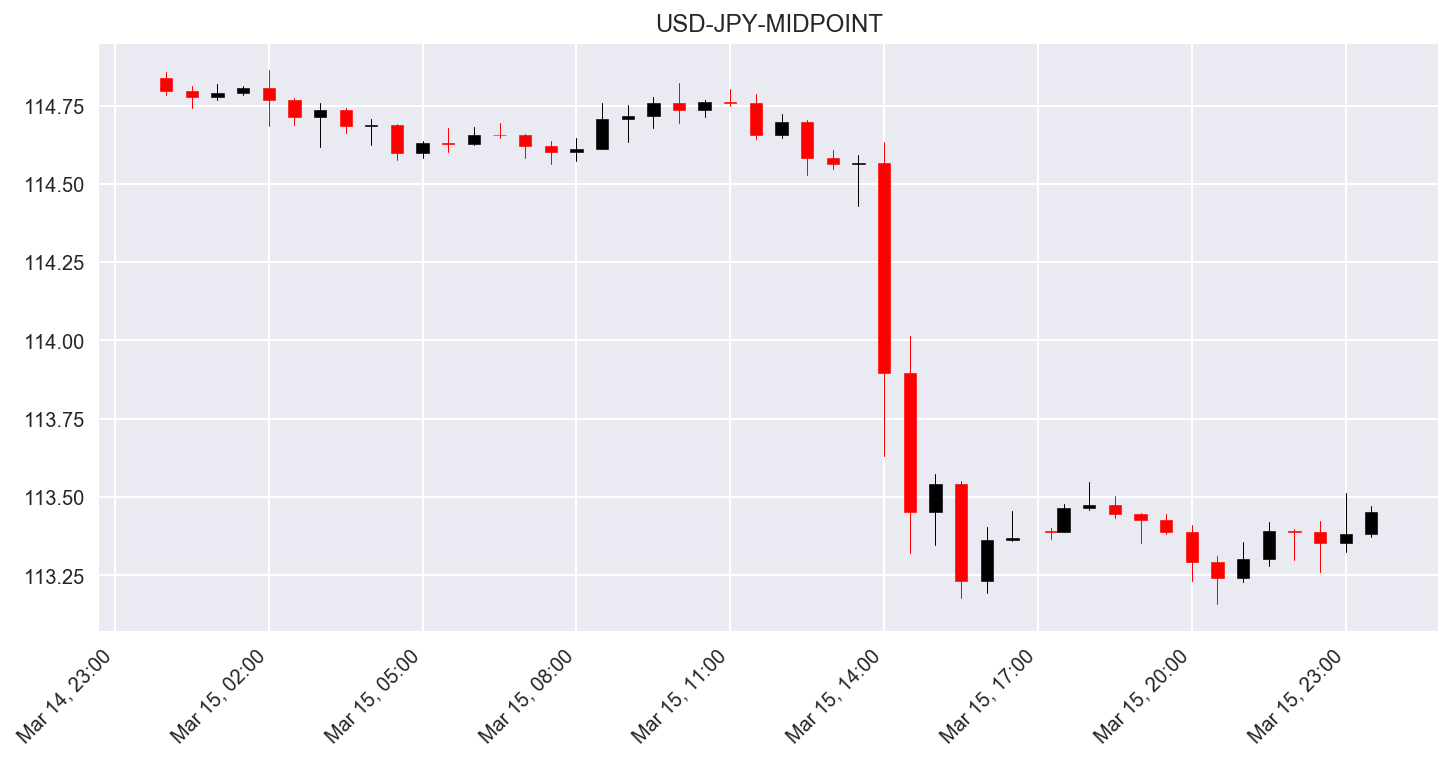

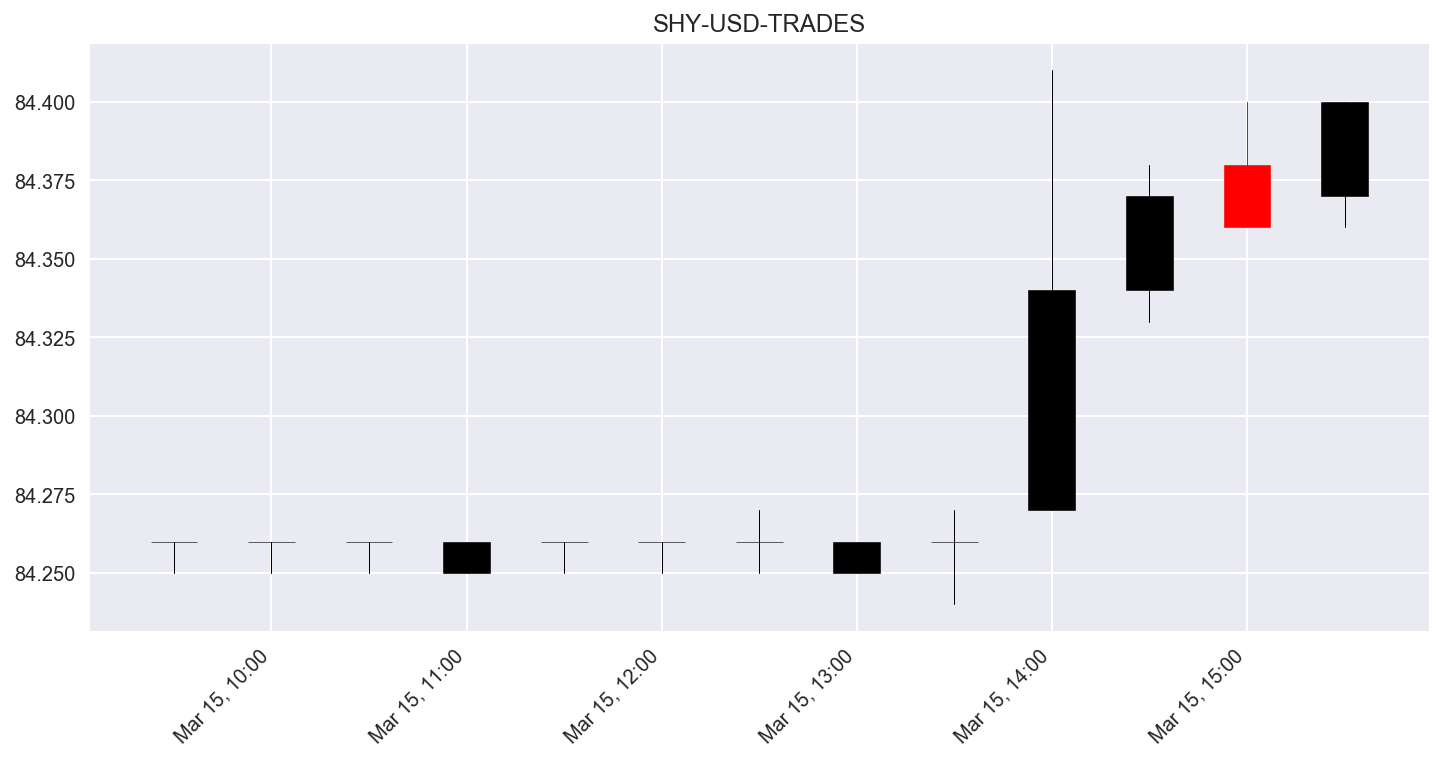

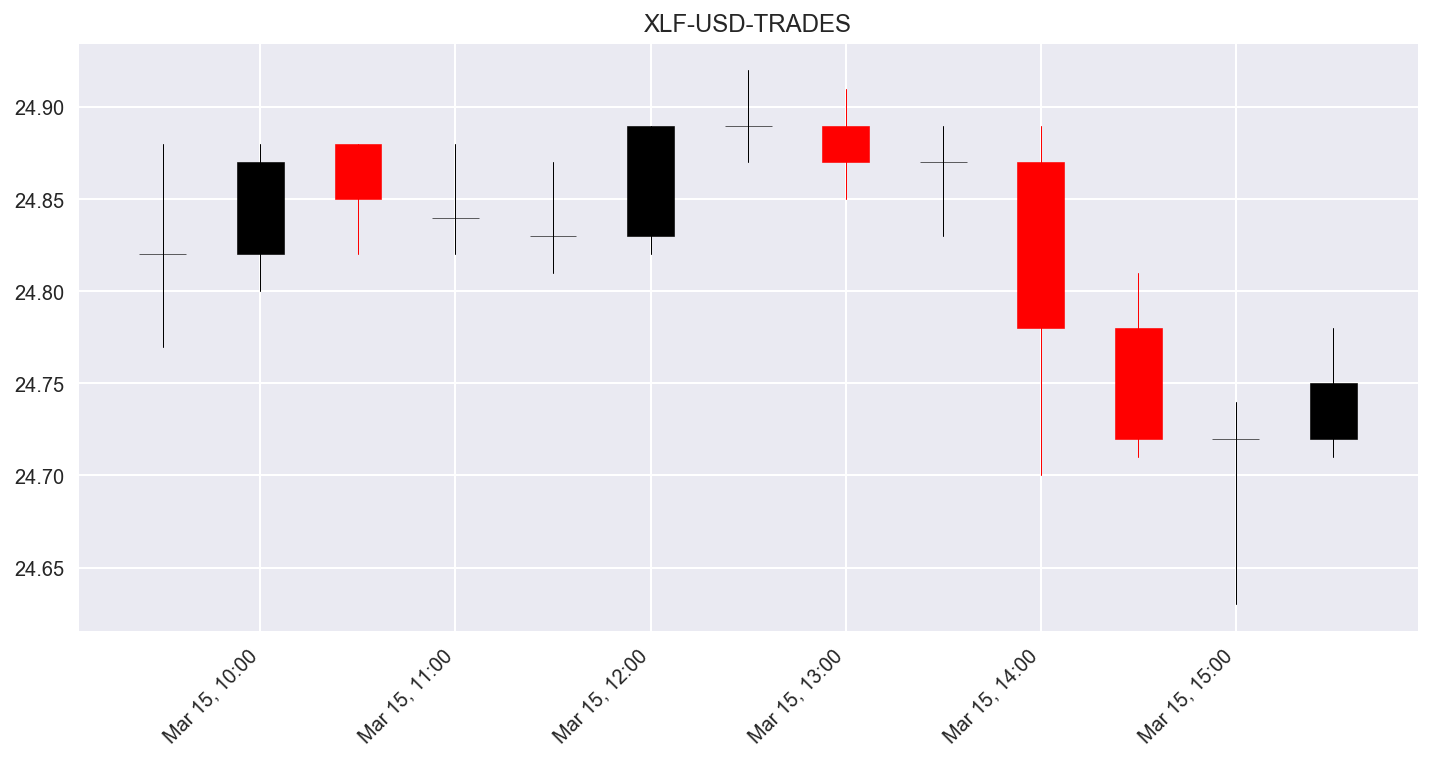

In [144]:
for key in fab.prices.keys():
    df = fab.prices[key].loc['2017-03-15']
    df.columns=['Open','High','Low','Close','Volume','Count','Wap','Close-MA-4']
    pandas_candlestick_ohlc(df, description=key)

In [141]:
fab.prices.keys()

dict_keys(['EUR-USD-MIDPOINT', 'XLU-USD-TRADES', 'XLB-USD-TRADES', 'GDX-USD-TRADES', 'XLY-USD-TRADES', 'OIL-USD-TRADES', 'XLV-USD-TRADES', 'SPY-USD-TRADES', 'SPY-OIV', 'USD-CAD-MIDPOINT', 'XLK-USD-TRADES', 'XLI-USD-TRADES', 'XLE-USD-TRADES', 'USD-JPY-MIDPOINT', 'SHY-USD-TRADES', 'XLF-USD-TRADES'])